# Quasar-host galaxy decomposition
This notebook simulates a quasar (unlensed) in a relatively faint galaxy. We then apply lenstronomy to fit and decomposite the different components. The quasar is modeled as an 'UNLENSED' point source, the host galaxy as part of the 'source_light_model' and lensing itself is ignored.

In [1]:
# import of standard python libraries
import numpy as np
import os
import time
import copy
import corner
import astropy.io.fits as pyfits

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

## data quality and psf choices for simulation

/Users/sibirrer/Library/Python/2.7/lib/python/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in log10


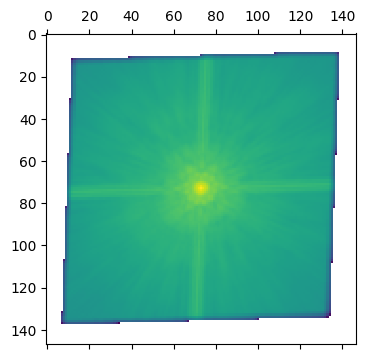

In [2]:
# import main simulation class of lenstronomy
from lenstronomy.SimulationAPI.simulations import Simulation
SimAPI = Simulation()

# import PSF file (here as a relative path in the lenstronomy_extension repository)
# the psf_example.fits file can be found here:
# https://github.com/sibirrer/lenstronomy_extensions/tree/master/Data/PSF_TinyTim
# and imported from a local file path as well
path = os.getcwd()
dirpath, _ = os.path.split(path)
module_path, _ = os.path.split(dirpath)
psf_filename = os.path.join(module_path, 'Data/PSF_TinyTim/psf_example.fits')
kernel = pyfits.getdata(psf_filename)

plt.matshow(np.log10(kernel))
plt.show()

    
# data specifics
background_rms = 0.1  #  background noise per pixel (Gaussian)
exp_time = 100.  #  exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix = 80  #  cutout pixel size
deltaPix = 0.05  #  pixel size in arcsec (area per pixel = deltaPix**2)
fwhm = 0.1  # full width half max of PSF (only valid when psf_type='gaussian')
psf_type = 'PIXEL'  # 'gaussian', 'pixel', 'NONE'
kernel_size = 91

# initial input simulation

# generate the coordinate grid and image properties
data_class = SimAPI.data_configure(numPix, deltaPix, exp_time, background_rms)
# generate the psf variables
psf_class = SimAPI.psf_configure(psf_type=psf_type, fwhm=fwhm, kernelsize=kernel_size, deltaPix=deltaPix, kernel=kernel)




## model choices
We model the quasar as a point source and the host galaxy as a two-component Sersic profile with joint center.

In [3]:
# quasar center (we chose a off-centered position)
center_x = 0.07
center_y = 0.01

# quasar brightness (as measured as the sum of pixel values)
point_amp = 10000 
from lenstronomy.PointSource.point_source import PointSource
point_source_list = ['UNLENSED']
pointSource = PointSource(point_source_type_list=point_source_list)
kwargs_ps = [{'ra_image': [center_x], 'dec_image': [center_y], 'point_amp': [point_amp]}]

from lenstronomy.LightModel.light_model import LightModel
light_model_list = ['SERSIC_ELLIPSE', 'SERSIC']
lightModel = LightModel(light_model_list=light_model_list)
import lenstronomy.Util.param_util as param_util
e1, e2 = param_util.phi_q2_ellipticity(phi=0.3, q=0.6)
kwargs_disk = {'I0_sersic': 1, 'n_sersic': 1, 'R_sersic': 0.7, 'e1': e1, 'e2': e2, 'center_x': center_x, 'center_y': center_y}
kwargs_buldge = {'I0_sersic': 1, 'n_sersic': 4, 'R_sersic': 0.3, 'center_x': center_x, 'center_y': center_y}
kwargs_host = [kwargs_disk, kwargs_buldge]


## make simulation
We now plug the components of data and model choices together and create a noisy image

/Users/sibirrer/Library/Python/2.7/lib/python/site-packages/scipy/signal/signaltools.py:375: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, complex) or
/Users/sibirrer/Library/Python/2.7/lib/python/site-packages/scipy/signal/signaltools.py:376: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(in2.dtype, complex))
/Users/sibirrer/Library/Python/2.7/lib/python/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in log10


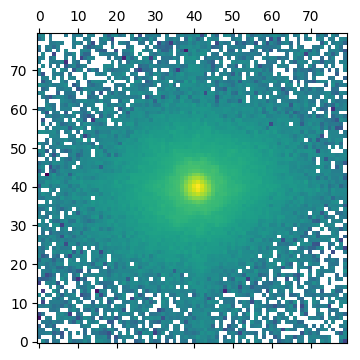

In [4]:
from lenstronomy.ImSim.image_model import ImageModel

kwargs_numerics = {'subgrid_res': 1, 'psf_subgrid': False}
imageModel = ImageModel(data_class, psf_class, source_model_class=lightModel,
                                point_source_class=pointSource, kwargs_numerics=kwargs_numerics)

# simulate image with the parameters we have defined above #
image = imageModel.image(kwargs_source=kwargs_host, kwargs_ps=kwargs_ps)

# we can also add noise #
import lenstronomy.Util.image_util as image_util
poisson = image_util.add_poisson(image, exp_time=exp_time)
bkg = image_util.add_background(image, sigma_bkd=background_rms)
image_noisy = image + bkg + poisson
plt.matshow(np.log10(image_noisy), origin='lower')
plt.show()

data_class.update_data(image_noisy)

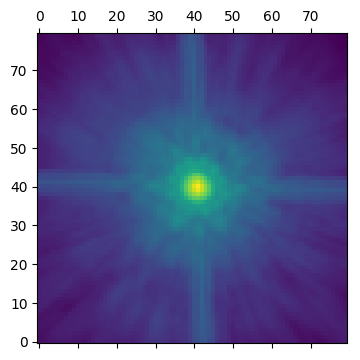

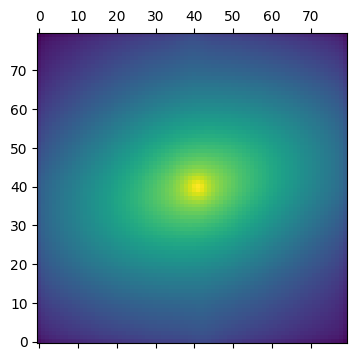

In [5]:
# we can also simulate the different components separately
imageModel_ps = ImageModel(data_class, psf_class, point_source_class=pointSource, kwargs_numerics=kwargs_numerics)
image_ps = imageModel_ps.image(kwargs_ps=kwargs_ps)
plt.matshow(np.log10(image_ps), origin='lower')
plt.show()

imageModel_host = ImageModel(data_class, psf_class, source_model_class=lightModel, kwargs_numerics=kwargs_numerics)
image_host = imageModel_host.image(kwargs_source=kwargs_host)
plt.matshow(np.log10(image_host), origin='lower')
plt.show()

## fitting the mock data with lenstronomy
We now use lenstronomy to recover the different components. To do so, we have to specify the allowed parameter space (upper and lower bounds), an initial guess (that can be crude) and an initial spread to initialize the solver. Additionally, we can keep parameters fixed, that we would not like to vary. E.g. the Sersic indices of a two component fit (buldge-to-disk).

In [6]:
# here are the options for the host galaxy fitting
fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []

# Disk component, as modelled by an elliptical Sersic profile
fixed_source.append({'n_sersic': 1})  # we fix the Sersic index to n=1 (exponential)
kwargs_source_init.append({'R_sersic': 1., 'n_sersic': 1, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0})
kwargs_source_sigma.append({'n_sersic_sigma': 0.5, 'R_sersic_sigma': 0.5, 'ellipse_sigma': 0.1, 'center_x_sigma': 0.1, 'center_y_sigma': 0.1})
kwargs_lower_source.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.001, 'n_sersic': .5, 'center_x': -10, 'center_y': -10})
kwargs_upper_source.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 5., 'center_x': 10, 'center_y': 10})

# Buldge component, as modelled by a spherical Sersic profile
fixed_source.append({'n_sersic': 4})  # we fix the Sersic index to n=4 (buldgy)
kwargs_source_init.append({'R_sersic': .5, 'n_sersic': 4, 'center_x': 0, 'center_y': 0})
kwargs_source_sigma.append({'n_sersic_sigma': 0.5, 'R_sersic_sigma': 0.3, 'center_x_sigma': 0.1, 'center_y_sigma': 0.1})
kwargs_lower_source.append({'R_sersic': 0.001, 'n_sersic': .5, 'center_x': -10, 'center_y': -10})
kwargs_upper_source.append({'R_sersic': 10, 'n_sersic': 5., 'center_x': 10, 'center_y': 10})

source_params = [kwargs_source_init, kwargs_source_sigma, fixed_source, kwargs_lower_source, kwargs_upper_source]

fixed_ps = [{}]
kwargs_ps_init = kwargs_ps
kwargs_ps_sigma = [{'pos_sigma': 0.01, 'pos_sigma': 0.01}]
kwargs_lower_ps = [{'ra_image': [-10], 'dec_image': [-10]}]
kwargs_upper_ps = [{'ra_image': [10], 'dec_image': [10]}]

ps_param = [kwargs_ps_init, kwargs_ps_sigma, fixed_ps, kwargs_lower_ps, kwargs_upper_ps]

kwargs_params = {'source_model': source_params,
               'point_source_model': ps_param}

## fitting options: see starter guide notebook.
For this particular example, we fix the extended host profile centers to the point source center. This does not necessary be the case and one might be able to detect off-sets.

In [7]:
kwargs_model = { 'source_light_model_list': light_model_list,
                'point_source_model_list': point_source_list
                 }

# numerical options and fitting sequences

kwargs_constraints = {'joint_center_source_light': True,  # if set to True, all the components in the host galaxy will have a shared center
                      'fix_to_point_source_list': [True, True],  # this results in a shared center of the host galaxy with the point source (quasar)
                      'num_point_source_list': [1]
                     }

kwargs_likelihood = {'check_bounds': True,
                     'source_marg': False,
                             }
kwargs_data = data_class.constructor_kwargs()
kwargs_psf = psf_class.constructor_kwargs()
image_band = [kwargs_data, kwargs_psf, kwargs_numerics]
multi_band_list = [image_band]

from lenstronomy.Workflow.fitting_sequence import FittingSequence

mpi = False  # MPI possible, but not supported through that notebook.

from lenstronomy.Workflow.fitting_sequence import FittingSequence
fitting_seq = FittingSequence(multi_band_list, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)

fitting_kwargs_list = [
        {'fitting_routine': 'PSO', 'mpi': False, 'sigma_scale': 1., 'n_particles': 50,
         'n_iterations': 50},
        {'fitting_routine': 'MCMC', 'n_burn': 100, 'n_run': 100, 'walkerRatio': 10, 'mpi': False,
         'sigma_scale': .1}
]

start_time = time.time()
lens_result, source_result, lens_light_result, ps_result, chain_list, param_list, samples_mcmc, param_mcmc, dist_mcmc = fitting_seq.fit_sequence(fitting_kwargs_list)
end_time = time.time()
print(end_time - start_time, 'total time needed for computation')
print('============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ ')

Computing the PSO ...
10
20
30
40
50
max iteration reached! stoping
(-1.0113084749655012, 'reduced X^2 of best position')
(-3232.6475402272245, 'logL')
(6393, 'effective number of data points')
([{}], 'lens result')
([{'R_sersic': 0.7072014533730441, 'I0_sersic': 1, 'n_sersic': 1, 'center_x': 0.07002634487644817, 'center_y': 0.009923077178473634, 'e1': 0.2126226697108344, 'e2': 0.15507810731121857}, {'n_sersic': 4, 'center_x': 0.07002634487644817, 'center_y': 0.009923077178473634, 'R_sersic': 0.35358941261711996, 'I0_sersic': 1}], 'source result')
([{}], 'lens light result')
([{'point_amp': 1, 'ra_image': array([0.07002634]), 'dec_image': array([0.00992308])}], 'point source result')
(18.464729070663452, 'time used for PSO', 'PSO')
Computing the MCMC...
('Number of walkers = ', 60)
('Burn-in iterations: ', 100)
('Sampling iterations:', 100)
InMemoryStorageUtil does not support storeRandomState
(88.73634099960327, 'time taken for MCMC sampling')
(107.23321485519409, 'total time needed f

[{'R_sersic': 0.7072014533730441, 'I0_sersic': 1, 'n_sersic': 1, 'center_x': 0.07002634487644817, 'center_y': 0.009923077178473634, 'e1': 0.2126226697108344, 'e2': 0.15507810731121857}, {'n_sersic': 4, 'center_x': 0.07002634487644817, 'center_y': 0.009923077178473634, 'R_sersic': 0.35358941261711996, 'I0_sersic': 1}]
('reduced chi^2 = ', 0.993547428208688)


/Users/sibirrer/Cosmology/Software/lenstronomy/lenstronomy/Plots/output_plots.py:239: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',
/Users/sibirrer/Cosmology/Software/lenstronomy/lenstronomy/Plots/output_plots.py:552: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data - model), origin='lower', vmin=v_min, vmax=v_max,


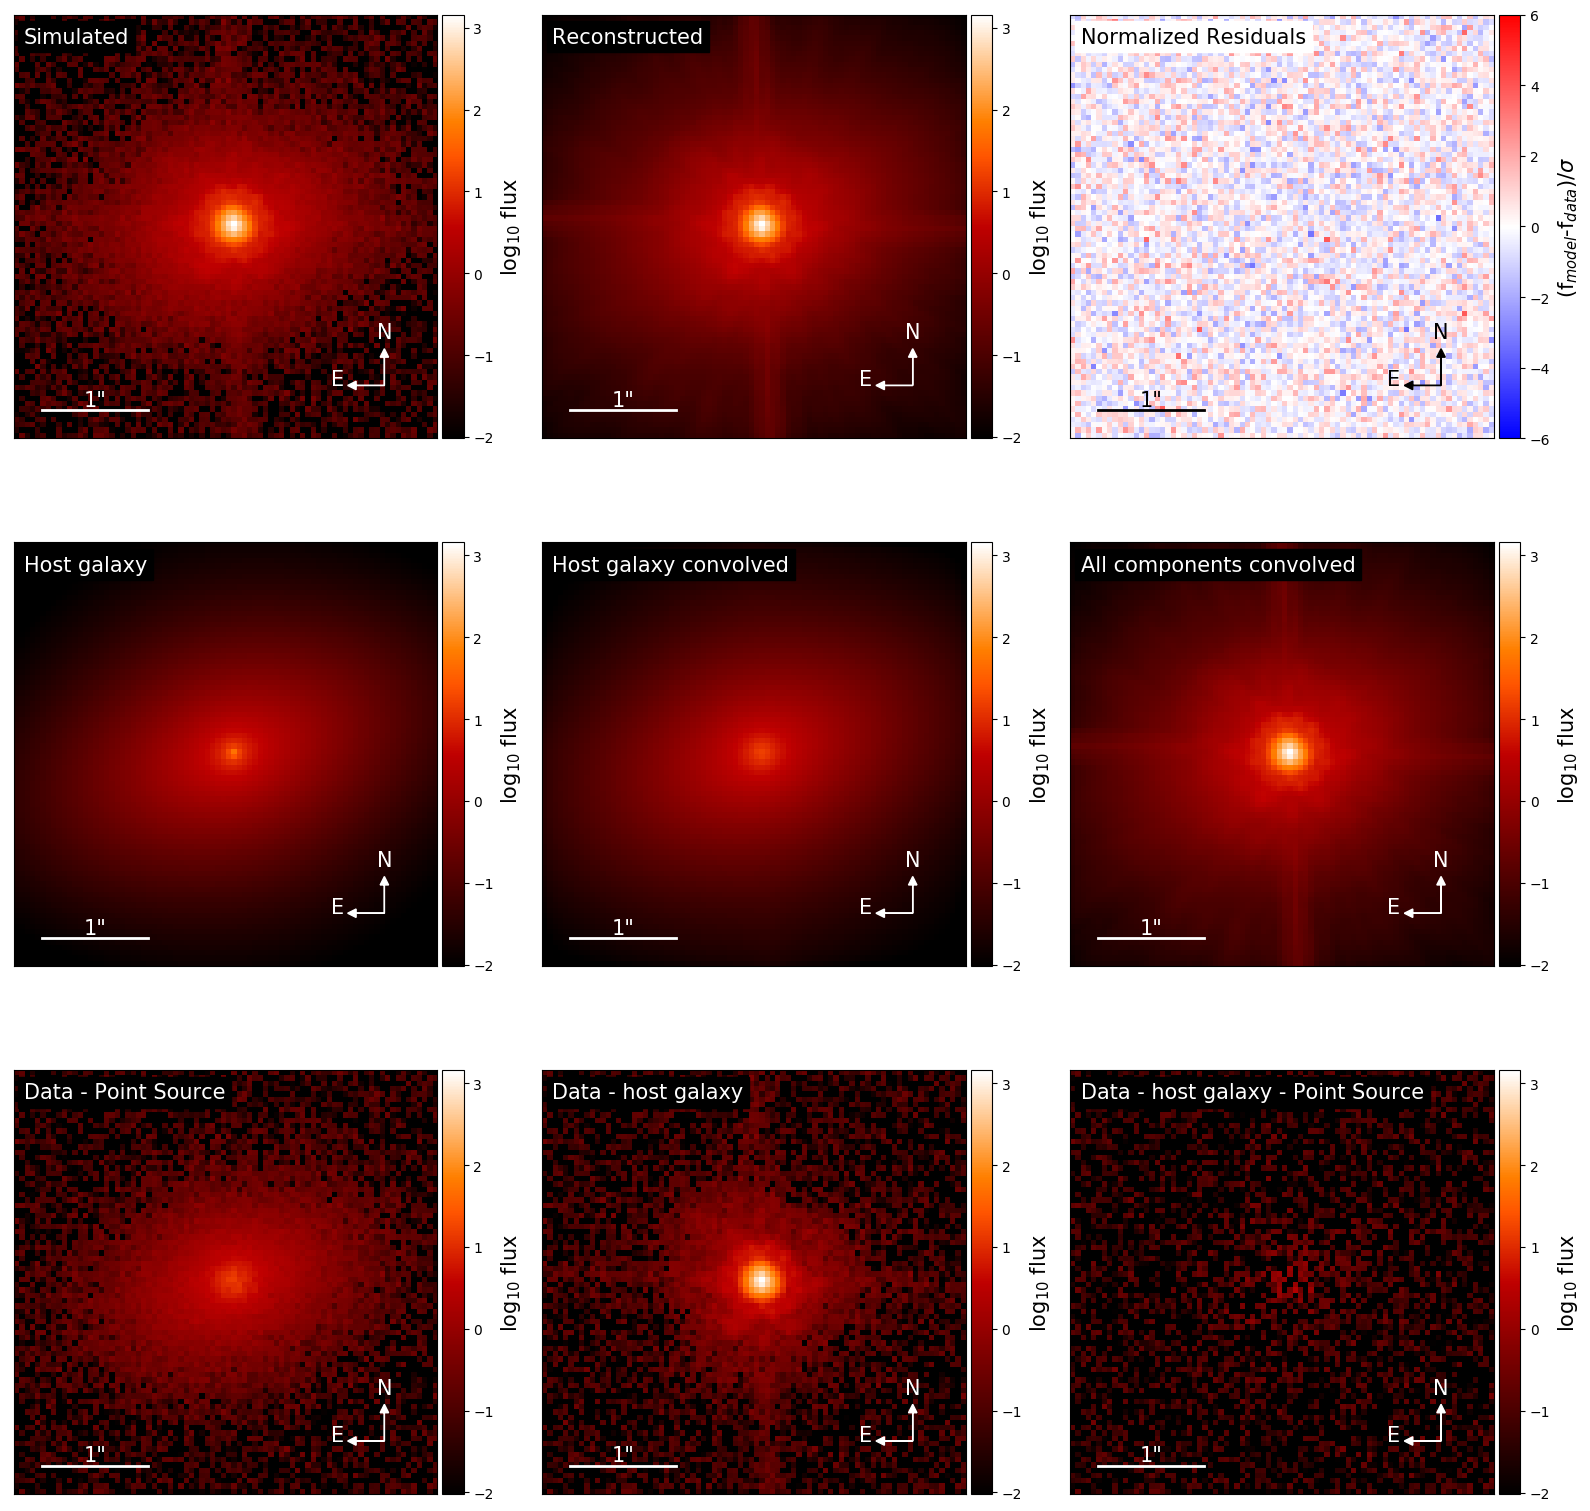

In [8]:
# let's plot the output of the PSO minimizer
print(source_result)
from lenstronomy.Plots.output_plots import LensModelPlot
lensPlot = LensModelPlot(kwargs_data, kwargs_psf, kwargs_numerics, kwargs_model, lens_result, source_result,
                             lens_light_result, ps_result, arrow_size=0.02, cmap_string="gist_heat", high_res=5)
    
f, axes = plt.subplots(3, 3, figsize=(16, 16), sharex=False, sharey=False)

lensPlot.data_plot(ax=axes[0,0], text="Simulated")
lensPlot.model_plot(ax=axes[0,1])
lensPlot.normalized_residual_plot(ax=axes[0,2], v_min=-6, v_max=6)

lensPlot.decomposition_plot(ax=axes[1,0], text='Host galaxy', source_add=True, unconvolved=True)
lensPlot.decomposition_plot(ax=axes[1,1], text='Host galaxy convolved', source_add=True)
lensPlot.decomposition_plot(ax=axes[1,2], text='All components convolved', source_add=True, lens_light_add=True, point_source_add=True)

lensPlot.subtract_from_data_plot(ax=axes[2,0], text='Data - Point Source', point_source_add=True)
lensPlot.subtract_from_data_plot(ax=axes[2,1], text='Data - host galaxy', source_add=True)
lensPlot.subtract_from_data_plot(ax=axes[2,2], text='Data - host galaxy - Point Source', source_add=True, point_source_add=True)

f.tight_layout()
#plt.savefig('/Users/sibirrer/Cosmology/Strong_Lensing/Papers/Lenstronomy/LenstronomyPaper/quasar_host_decomposition.pdf', format='pdf')
#f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()


/Users/sibirrer/Library/Python/2.7/lib/python/site-packages/ipykernel/__main__.py:3: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  app.launch_new_instance()


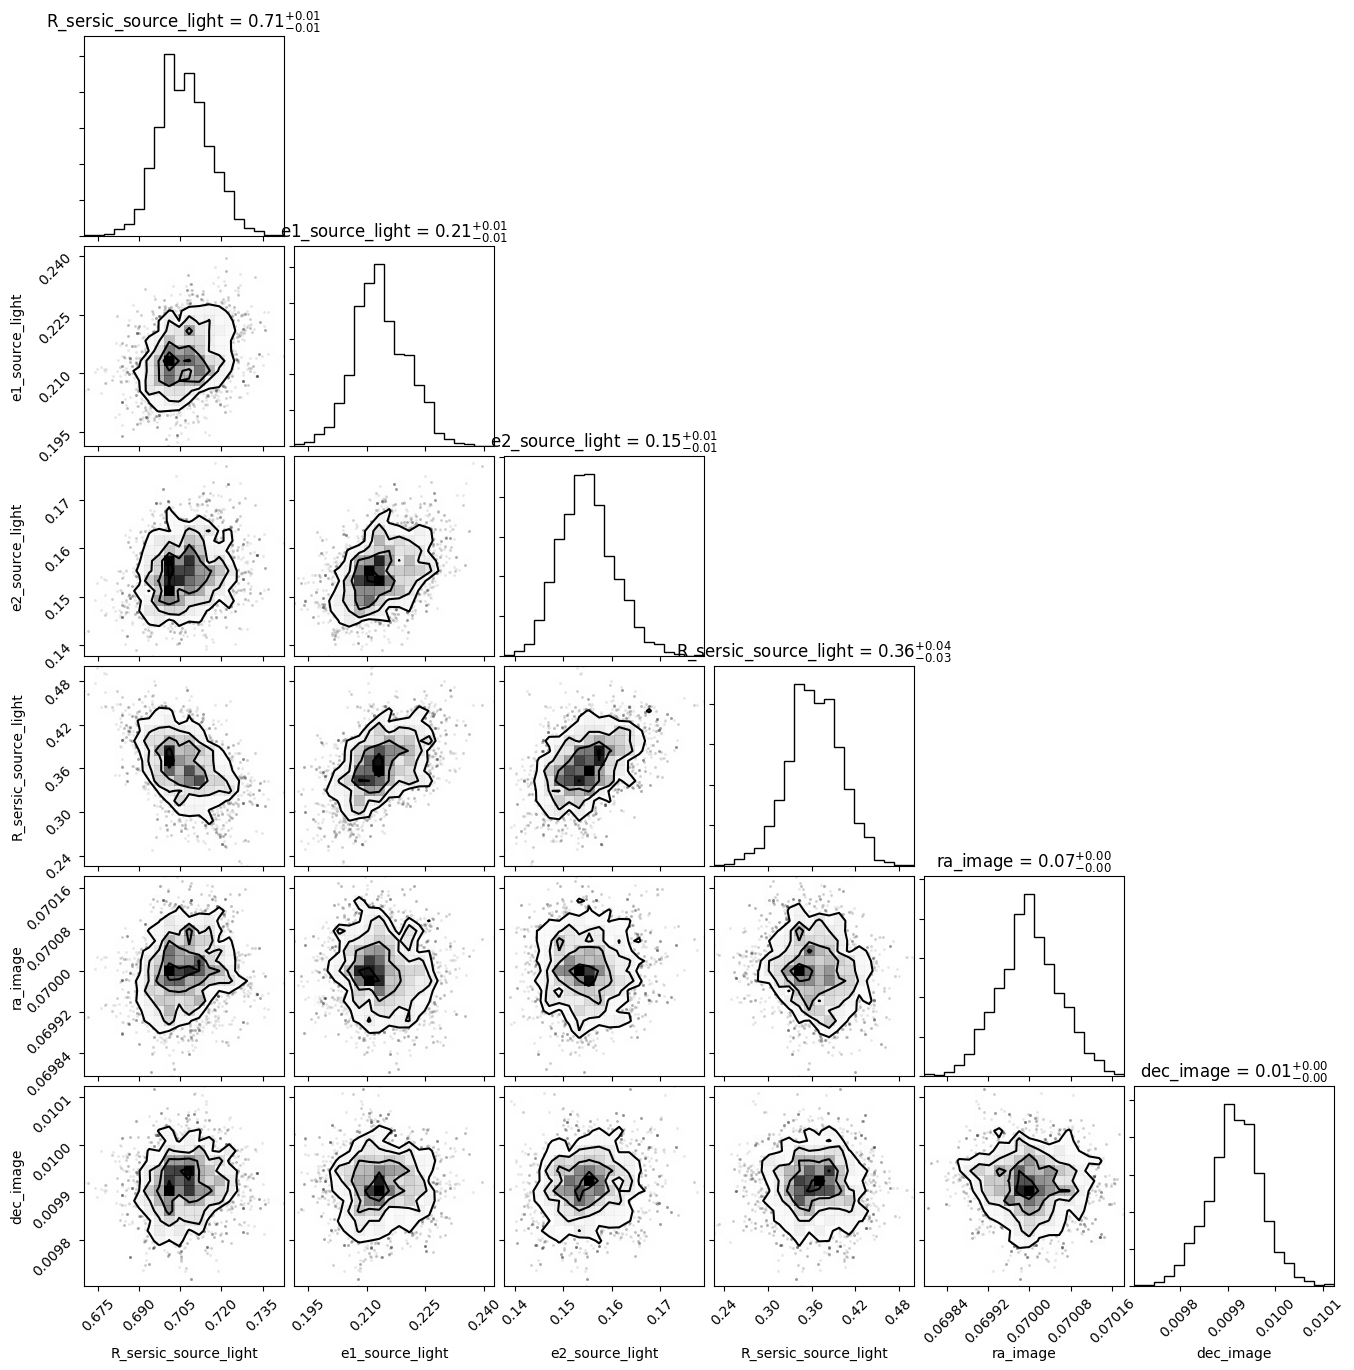

In [9]:
# here the (non-converged) MCMC chain of the non-linear parameters
import corner
if not samples_mcmc == []:
        n, num_param = np.shape(samples_mcmc)
        plot = corner.corner(samples_mcmc, labels=param_mcmc, show_titles=True)

## making flux measurements with lenstronomy
We now take the resulting fits and compute the fluxes in each component. Those fluxes can then be turned into magnitudes, provided a flux calibration. **lenstronomy** does not fit for the linear flux amplitudes of the different profiles, but solves for them with a linear inversion. To extract those coefficients, one has to re-perform this inversion.

In [10]:
# this is the linear inversion. The kwargs will be updated afterwards
image_reconstructed, _, _, _ = imageModel.image_linear_solve(kwargs_source=source_result, kwargs_ps=ps_result)
print(source_result)
# flux count in point source
image_ps = imageModel.point_source(ps_result)
print np.sum(image_ps)
print ps_result
# for point sources, the fluxes in 'point_amp' are equivalent to the flux counts in the image.
# The only difference is the smaller cutout size in the image

# flux count in host galaxy
image_host = imageModel.source_surface_brightness(source_result)
print np.sum(image_host)

# if we only want the first component (disk in our case), we can do that
image_disk = imageModel.source_surface_brightness(source_result, k=0)
print np.sum(image_disk)

# and if we only want the second component (buldge in our case)
image_buldge = imageModel.source_surface_brightness(source_result, k=1)
print np.sum(image_buldge)

# to summarize
print("quasar-to-host galaxy ratio: ", np.sum(image_ps)/np.sum(image_host))
print("buldge-to-disk ratio:", np.sum(image_buldge)/np.sum(image_disk))

[{'R_sersic': 0.7072014533730441, 'I0_sersic': 0.9597179752768343, 'n_sersic': 1, 'center_x': 0.07002634487644817, 'center_y': 0.009923077178473634, 'e1': 0.2126226697108344, 'e2': 0.15507810731121857}, {'n_sersic': 4, 'center_x': 0.07002634487644817, 'center_y': 0.009923077178473634, 'R_sersic': 0.35358941261711996, 'I0_sersic': 0.7621540586225714}]
9983.90768058272
[{'point_amp': array([10018.7290268]), 'ra_image': array([0.07002634]), 'dec_image': array([0.00992308])}]
2089.233810418924
1306.468359543673
782.7654508752512
('quasar-to-host galaxy ratio: ', 4.77874119727212)
('buldge-to-disk ratio:', 0.5991461218001926)


## post-process mcmc chain to plot posteriors on the flux estimates

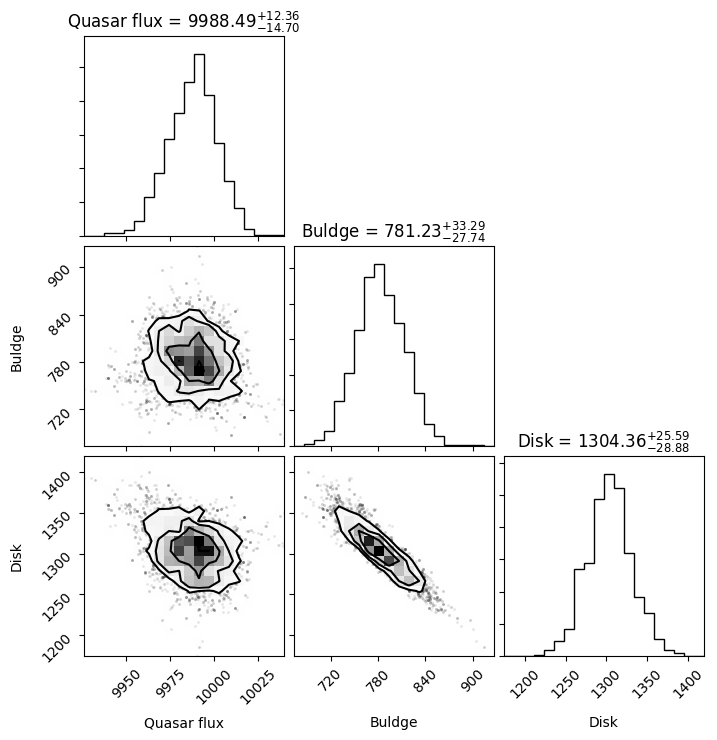

In [11]:
from lenstronomy.Workflow.parameters import Param
param = Param(kwargs_model, kwargs_constraints, kwargs_fixed_source=fixed_source, kwargs_fixed_ps=fixed_ps)

mcmc_new_list = []
labels_new = [r"Quasar flux", r"Buldge", r"Disk"]
for i in range(len(samples_mcmc)):
    # transform the parameter position of the MCMC chain in a lenstronomy convention with keyword arguments #
    kwargs_lens_out, kwargs_light_source_out, kwargs_light_lens_out, kwargs_ps_out = param.getParams(samples_mcmc[i])
    image_reconstructed, _, _, _ = imageModel.image_linear_solve(kwargs_source=kwargs_light_source_out, kwargs_ps=kwargs_ps_out)

    image_ps = imageModel.point_source(kwargs_ps_out)
    flux_quasar = np.sum(image_ps)
    image_disk = imageModel.source_surface_brightness(kwargs_light_source_out, k=0)
    flux_disk = np.sum(image_disk)
    image_buldge = imageModel.source_surface_brightness(kwargs_light_source_out, k=1)
    flux_buldge = np.sum(image_buldge)
    mcmc_new_list.append([flux_quasar, flux_buldge, flux_disk])

plot = corner.corner(mcmc_new_list, labels=labels_new, show_titles=True)